In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# ÂÆö‰πâÂõ†Â≠êÔºÅ

In [4]:
def factor(df, window=20):
    """
    ÊîπËøõÔºöËØÜÂà´È´òÈ¢ë‰∫§ÊòìÂÜ≤ÂáªÊ®°ÂºèÔºåÊçïÊçâÂ∏ÇÂú∫ÂæÆËßÇÁªìÊûÑÂèòÂåñ
    ÈáëËûçÊÑè‰πâÔºöÊ£ÄÊµãÁ®ãÂ∫èÂåñ‰∫§ÊòìÂØºËá¥ÁöÑÁõòÂè£ÂºÇÂ∏∏Ë°å‰∏∫
    """
    df = df.copy()
    # ËÆ°ÁÆóÈ´òÈ¢ëÂÜ≤ÂáªÊåáÊ†á
    df['mid_price'] = (df['high'] + df['low']) / 2
    df['price_slope'] = df['mid_price'].diff() / df['volume'].replace(0, 1)
    df['impact'] = np.where(df['price_slope'].abs() > df['price_slope'].rolling(50).mean() * 2, 
                           np.sign(df['price_slope']), 0)
    
    daily_results = []
    for date, group in df.groupby(pd.Grouper(freq='D')):
        if len(group) < 4:
            continue
            
        time_idx = np.arange(len(group))
        # ÂÜ≤ÂáªÊñπÂêëÂàÜÁ±ª
        buy_impact_mask = group['impact'] > 0
        sell_impact_mask = group['impact'] < 0
        
        # ‰π∞ÊñπÂÜ≤ÂáªÈáçÂøÉ
        if buy_impact_mask.any():
            buy_weights = group.loc[buy_impact_mask, 'volume']
            G_buy = np.sum(time_idx[buy_impact_mask] * buy_weights) / buy_weights.sum()
        else:
            G_buy = np.nan
            
        # ÂçñÊñπÂÜ≤ÂáªÈáçÂøÉ
        if sell_impact_mask.any():
            sell_weights = group.loc[sell_impact_mask, 'volume']
            G_sell = np.sum(time_idx[sell_impact_mask] * sell_weights) / sell_weights.sum()
        else:
            G_sell = np.nan
            
        daily_results.append({
            'date': date,
            'G_buy': G_buy,
            'G_sell': G_sell,
            'impact_ratio': buy_impact_mask.mean() / (sell_impact_mask.mean() + 1e-10)
        })
    
    daily_df = pd.DataFrame(daily_results).set_index('date')
    
    # ÂÜ≤ÂáªÈáçÂøÉÂÅèÁ¶ªÊ®°Âûã
    residuals = []
    for i in range(window, len(daily_df)):
        train_data = daily_df.iloc[i-window:i].dropna()
        if len(train_data) < 10:
            residuals.append(np.nan)
            continue
            
        # ÂÜ≤ÂáªÊØî‰æã‰Ωú‰∏∫ÁâπÂæÅ
        X = train_data[['G_buy', 'impact_ratio']].values
        y = train_data['G_sell'].values
        model = LinearRegression().fit(X, y)
        
        current = daily_df.iloc[i]
        if pd.isna(current['G_buy']) or pd.isna(current['G_sell']):
            residuals.append(np.nan)
        else:
            pred_G_sell = model.predict([[current['G_buy'], current['impact_ratio']]])[0]
            residuals.append(current['G_sell'] - pred_G_sell)
    
    daily_df = daily_df.iloc[window:]
    daily_df['residual'] = residuals
    
    # ÂÜ≤ÂáªÂº∫Â∫¶Ë∞ÉÊï¥
    impact_strength = daily_df['impact_ratio'].diff().abs().rolling(3).mean()
    daily_df['factor'] = daily_df['residual'].rolling(window).mean() * impact_strength
    
    df['factor_value'] = np.nan
    for date, row in daily_df.iterrows():
        mask = (df.index.date == date.date())
        df.loc[mask, 'factor_value'] = row['factor']
    
    return -df['factor_value']

# ÊµãËØïÂõ†Â≠êË°®Áé∞


üìä ÂçïÂ∏ÅÁßç (single) ËØ¶ÁªÜËØÑ‰º∞ÁªìÊûú:
--------------------------------------------------
üîó Áõ∏ÂÖ≥ÊÄßÂàÜÊûê:
   IC (Pearson): 0.022266
   Rank_IC (Spearman): 0.024398
üìä ‰ø°ÊÅØÊØîÁéá:
   IR: 0.448465
   ÊúâÊïàÂàÜÁªÑÊï∞: 10
üìä Âõ†Â≠êÂàÜÂ∏É:
üìã Êï∞ÊçÆÊ¶ÇÂÜµ:
   Êï∞ÊçÆÈïøÂ∫¶: 127291
   Âõ†Â≠êÂàó: factor
   Êî∂ÁõäÁéáÂàó: future_return
   Êú™Êù•Êî∂ÁõäÂë®Êúü: 10
--------------------------------------------------

üñºÔ∏è  ÂçïÂ∏ÅÁßç (single) ÂõæÁâáÂ±ïÁ§∫:
----------------------------------------


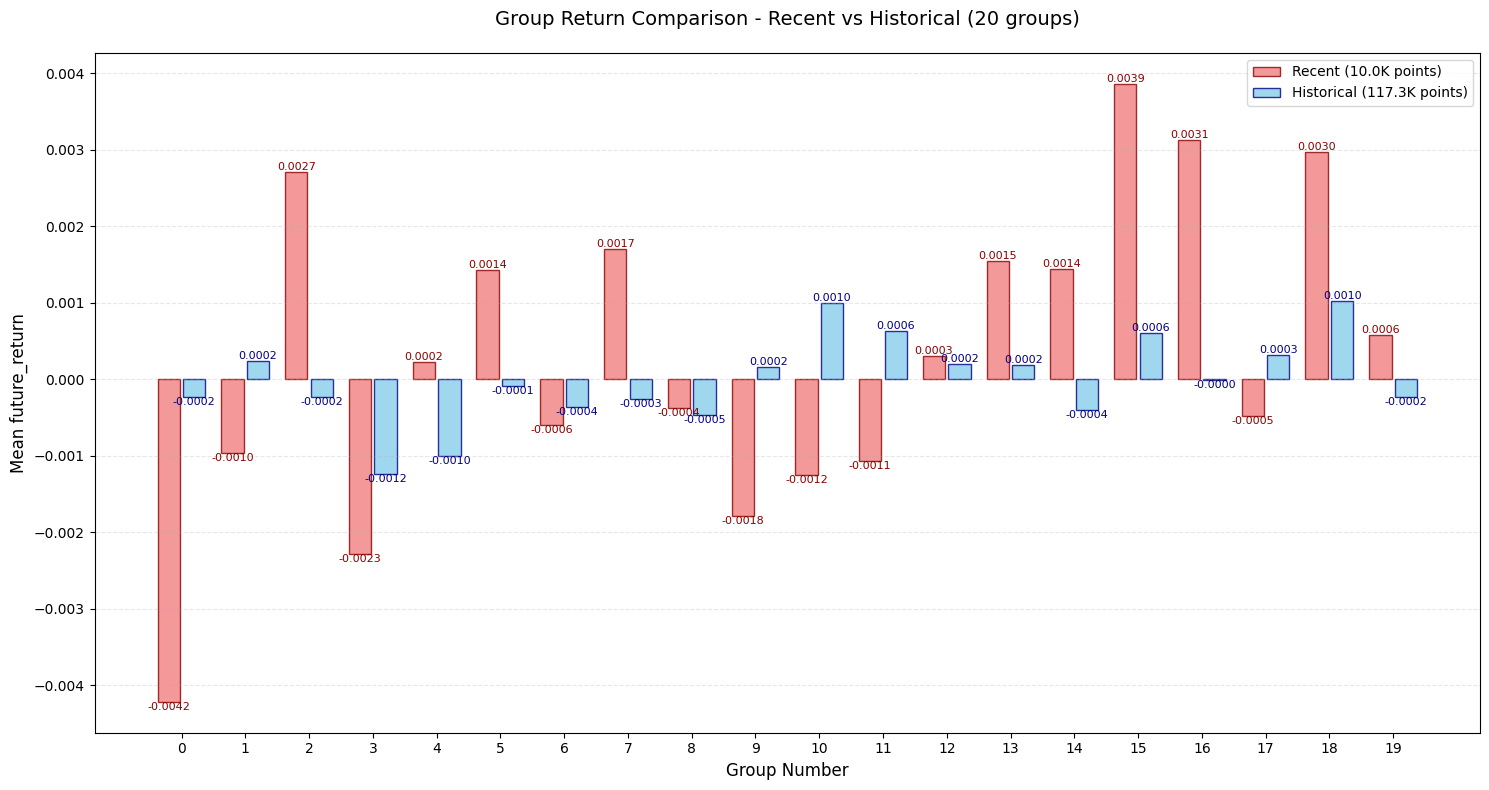

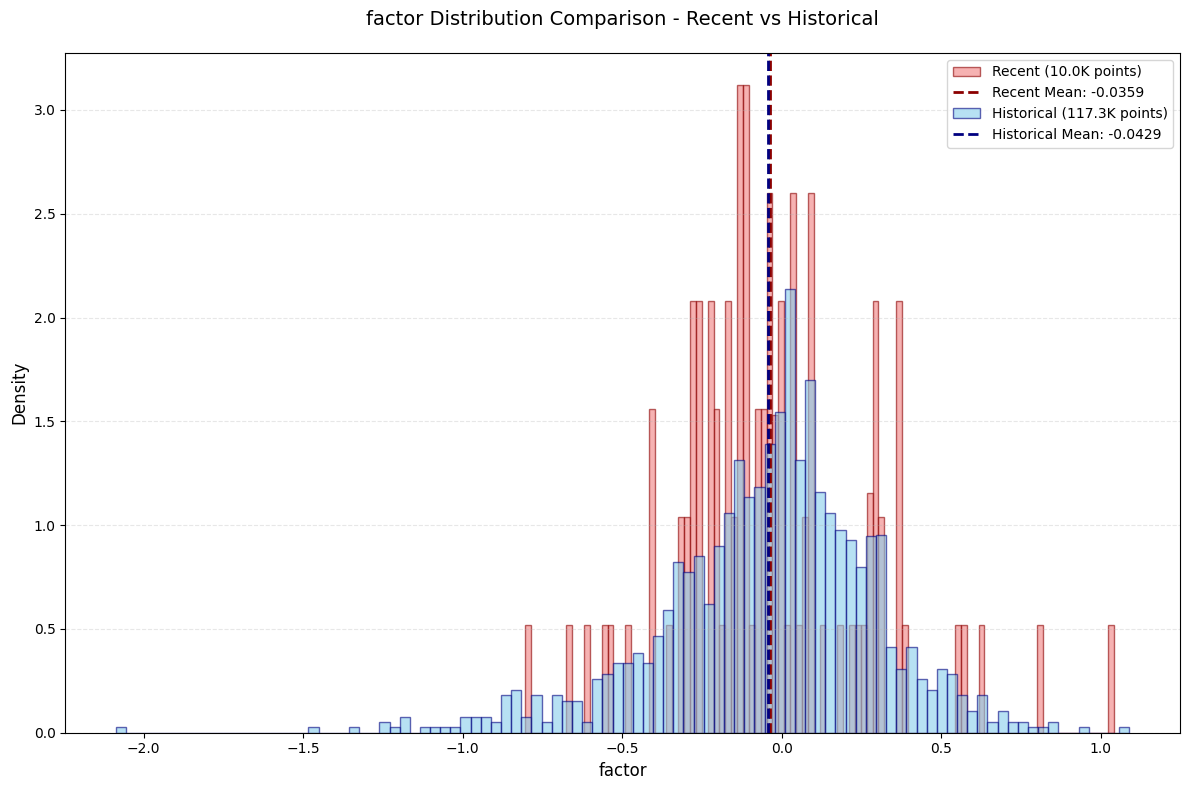

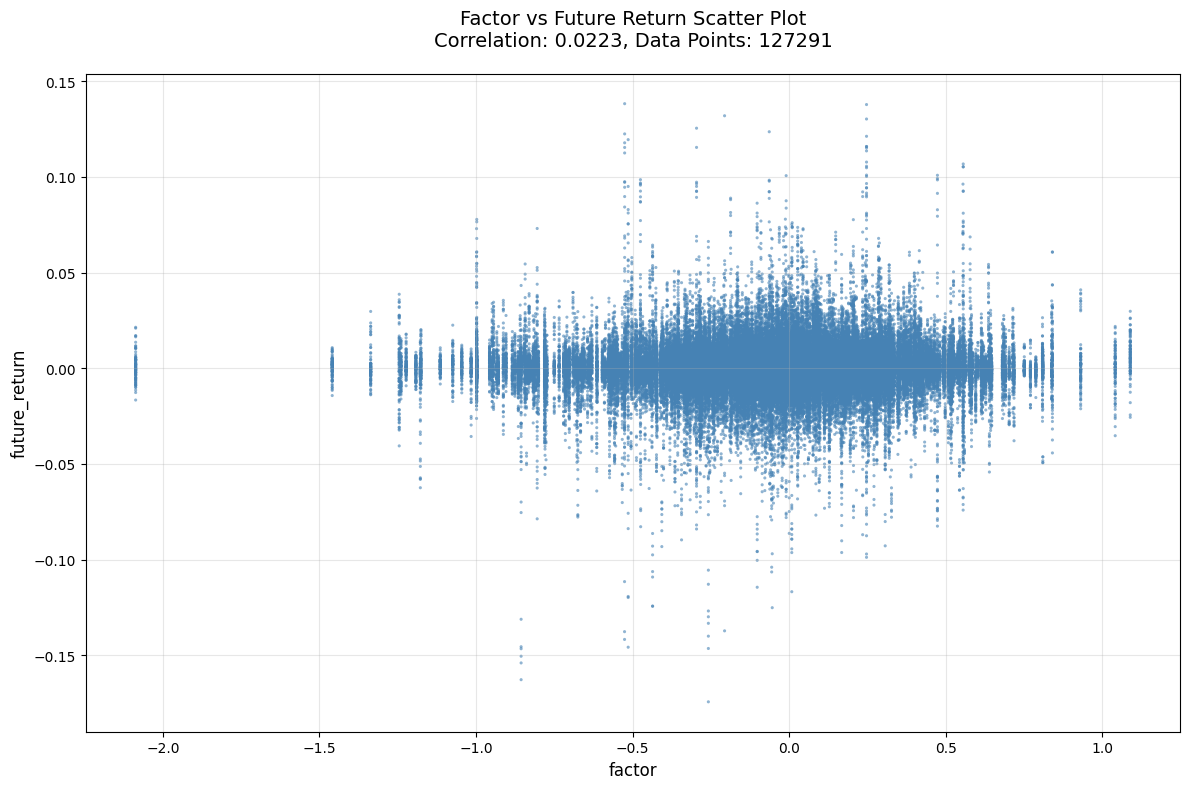

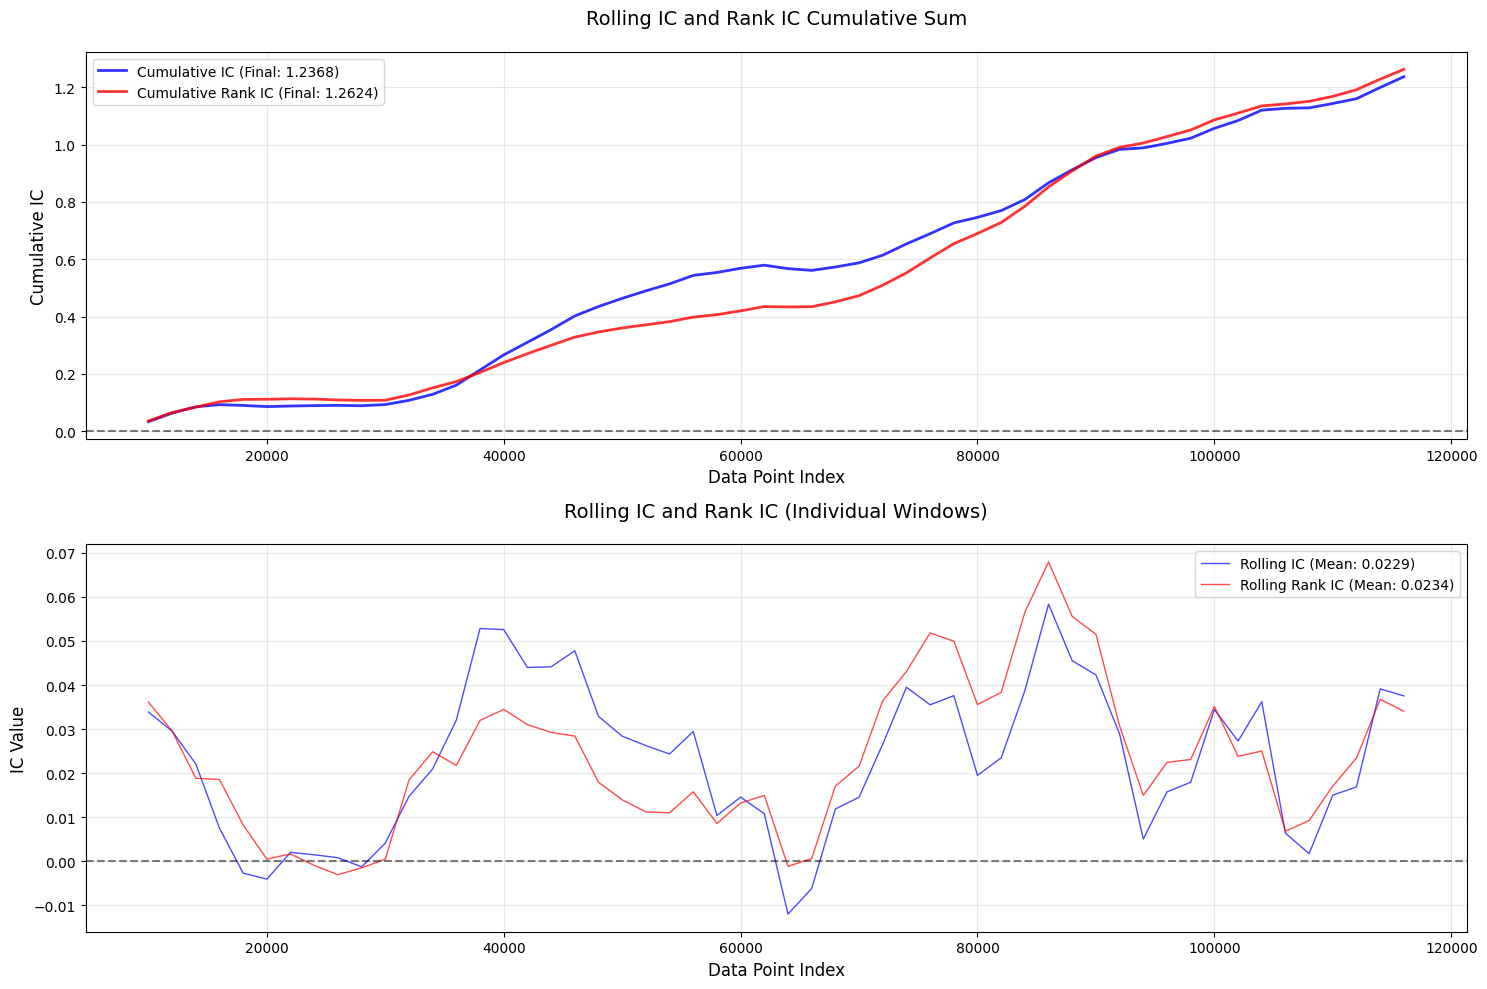

‚úÖ Â∑≤ÊòæÁ§∫ 4 ‰∏™ÂõæÁâá
----------------------------------------


In [5]:
evaluator.set_factor(
    factor_func=lambda df: factor(df),
    factor_name='factor'
)

result=evaluator.run_full_evaluation(run_stationarity_test=False)

In [6]:
result['information_ratio']['group_correlations']
# ËøôË°®Á§∫‰∏çÂêåÂàÜÁªÑ‰πãÈó¥ÁöÑÁõ∏ÂÖ≥ÊÄßÔºåÈÄöÂ∏∏Áî®‰∫éËØÑ‰º∞Âõ†Â≠êÂú®‰∏çÂêåÂ∏ÇÂú∫Áä∂ÊÄÅ‰∏ãÁöÑË°®Áé∞‰∏ÄËá¥ÊÄß„ÄÇ
# Â¶ÇÊûúÁõ∏ÂÖ≥ÊÄßËæÉÈ´òÔºåËØ¥ÊòéÂõ†Â≠êÂú®‰∏çÂêåÂ∏ÇÂú∫Áä∂ÊÄÅ‰∏ãË°®Áé∞‰∏ÄËá¥ÔºõÂ¶ÇÊûúÁõ∏ÂÖ≥ÊÄßËæÉ‰ΩéÔºåËØ¥ÊòéÂõ†Â≠êÂú®‰∏çÂêåÂ∏ÇÂú∫Áä∂ÊÄÅ‰∏ãË°®Áé∞Â∑ÆÂºÇËæÉÂ§ß„ÄÇ

[-0.010839259892752728,
 -0.03409473691989445,
 0.0377492466582324,
 0.006868698388161525,
 0.03323965276100867,
 0.0016462761340237434,
 0.01662445249189629,
 0.07029112341296456,
 0.02197688639541925,
 -0.015384767268795896]

In [7]:
print(result)

{'correlation_analysis': {'IC': 0.022266139542211752, 'Rank_IC': 0.024397613801120634}, 'information_ratio': {'IR': 0.44846527100347744, 'group_correlations': [-0.010839259892752728, -0.03409473691989445, 0.0377492466582324, 0.006868698388161525, 0.03323965276100867, 0.0016462761340237434, 0.01662445249189629, 0.07029112341296456, 0.02197688639541925, -0.015384767268795896], 'n_groups': 10}, 'group_analysis': {'group_stats':        val_min  val_max  val_mean  return_mean  return_std  count
group                                                            
0      -2.0871  -0.6552   -0.8948      -0.0004      0.0124   6432
1      -0.6532  -0.4469   -0.5312       0.0000      0.0140   6336
2      -0.4468  -0.3362   -0.3872      -0.0004      0.0124   6336
3      -0.3357  -0.2766   -0.3071      -0.0011      0.0128   6432
4      -0.2764  -0.2144   -0.2478      -0.0009      0.0118   6336
5      -0.2142  -0.1641   -0.1866      -0.0000      0.0108   6336
6      -0.1637  -0.1247   -0.1429      -0.0